### Importing libraries

In [12]:
import pandas as pd
import numpy as np
import os

from scipy import stats
from sklearn.linear_model import LassoCV
from datetime import datetime, timedelta

from plotly import express as px
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Video, Image

import matplotlib
from matplotlib.colors import LinearSegmentedColormap

import shap
from BorutaShap import BorutaShap
from lightgbm import LGBMRegressor

In [13]:
import os
os.chdir('C:/Users/Xavi/Desktop/Memorable/modules')
import lasso_model_library as lasso
import ca_plots as ca_plt

os.chdir('C:/Users/Xavi/Desktop/Memorable/Projects/Sedal')

----
### Loading data




In [14]:
df = pd.read_csv('data/hair_care/hair_care_tags_with_metrics.csv')
df = df.loc[df.brand!='Sedal Argentina']

df = df.loc[df.tag_type!='TEXT']

df = df.loc[df.tag_type!='SUPER_NOUN']
df = df.loc[df.tag_type!='SUPER_ADJ']
df = df.loc[df.tag_type!='SUPER_VERB']
df = df.loc[df.tag_type!='COLORFULNESS']
df = df.loc[df.tag_type!='BRIGHTNESS']

df = df.loc[df.tag_type!='LOGO_SPATIAL']
df = df.loc[df.tag_type!='LOGO']
df = df.loc[df.tag_type!='LOGO_TEMPORAL_PCT']
df = df.loc[df.tag_type!='LOGO_TEMPORAL_SEC']

In [15]:
df['tag_name'] = df['tag_name'].replace('female', 'lali esposito')
df['tag_name'] = df['tag_name'].replace('hygienics', 'hygienic products')
df['tag_name'] = df['tag_name'].replace('business', 'product layout')
df['tag_name'] = df['tag_name'].replace('healthcare', 'haircare')

df['tag_name'] = df['tag_name'].replace('growth', 'plants')
df['tag_name'] = df['tag_name'].replace('fashion', 'hair touching')
df['tag_name'] = df['tag_name'].replace('outdoors', 'light background')


df = df.loc[df.tag_name!='no person']
df = df.loc[df.tag_name!='horizontal']
df = df.loc[df.tag_name!='vertical']
df = df.loc[df.tag_name!='vector']
df = df.loc[df.tag_name!='lali espsito']
df = df.loc[df.tag_name!='people']
df = df.loc[df.tag_name!='indoors']
df = df.loc[df.tag_name!='portrait']
df = df.loc[df.tag_name!='clothing']
df = df.loc[df.tag_name!='adult']

#----BAI-----
#df = df.loc[df.tag_name!='adult']


#----CTR-----
#df = df.loc[df.tag_name!='woman']

In [16]:
len(df), df.asset_id.nunique()

(201886, 1053)

In [17]:
#assets_with_logo = df[['asset_id', 'tag_name', 'tag_type', 'bai']].loc[df.tag_type=='LOGO_SPATIAL'].asset_id.unique()
#
#for i,id in enumerate(df.asset_id.unique()):
#    if id not in assets_with_logo:
#        df = df.loc[df.asset_id!=id]

In [18]:
len(df), df.asset_id.nunique()

(201886, 1053)

In [19]:
#df = df.loc[df.bai!=0]

In [20]:
df.loc[df.fileType=='VIDEO'].asset_id.nunique(), df.loc[df.fileType=='IMAGE'].asset_id.nunique()

(423, 630)

In [21]:
df.tag_type.unique()

array(['OBJECT', 'AESTHETICS', 'COLOR', 'CONTRAST', 'LABEL', 'FACE',
       'CELEBRITY'], dtype=object)

### Optional Cells (to separate in the future)

In [22]:
# convert to datetime
date_col = 'created_time'
df[date_col] = '01-01-2022'
df[date_col] = pd.to_datetime(df[date_col]).copy()
df[date_col] = df[date_col].apply(lambda x: x.date()).copy()

#--------------------------

obj_col = 'campaign_objective'
df[obj_col] = 'objective_no_real'

# -------------------------

# convert confident values higher than 100
df['confidence'] = df['confidence'].apply(lambda x: x/100 if x > 1 else x)

df = df.loc[df.confidence>0.9]

df.tag_name = df.tag_name.astype(str)
df.tag_name = df.tag_name.str.lower()
df = df.reset_index(drop=True)

---
### Processing target metric

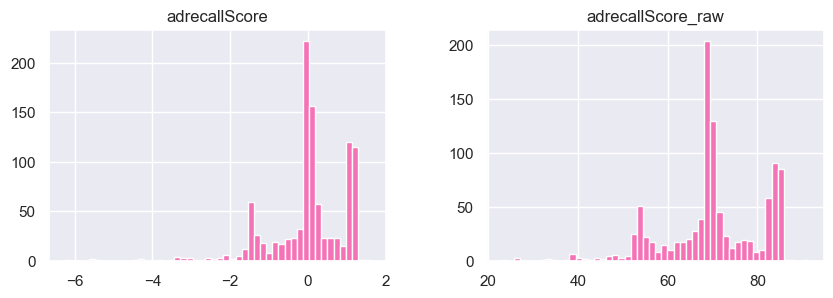

In [23]:
# Parameters ----------------------------------------------------------
index_col = ['asset_id']
metric = 'adrecallScore'
norm_metric = True
print_metric = True
transform_type = 'log'
lmbda = 0
transform_coef = 1e-3
#------------------------------------------------------------------------------------

metrics = lasso.process_metrics(df, index_col, metric, transform_type, transform_coef, lmbda=lmbda, norm_metric=norm_metric,
                                print_metric=print_metric, figsize=(10,3))

In [34]:
metrics

,adrecallScore,adrecallScore_raw
asset_id,,
01GGRE5ZJWD969FC0DM7XCQNYM,0.080717,69.9875
01GGRE5ZJX7FRQ4433HN033P0G,-0.028785,68.6625
01GGRE5ZJXJTM9EWAHQKVCTRBG,-1.452965,53.5500
01GGRE5ZJXZ8SNYE9S2JBN4W3F,-0.672760,61.3625
01GGRE5ZJY74KJ8459BC1GZEB4,0.018992,69.2375
...,...,...
01GKHE5HAF0W6VYTWCV1R1J6RV,-0.887816,59.1018
01GKHE5HAF9B2FYNPCP78E3PHD,-0.697303,61.1002
01GKHG3XND0APP0EWFF4C8DHXJ,1.178896,84.7750


### Preprocessing data

In [24]:
# PARAMETROS MODIFICABLES ----------------------------------------------------------

date_col = 'created_time'
objective_col = 'campaign_objective'
tag_type_col = 'tag_type'
tag_name_col = 'tag_name'
tag_id_col = 'tag_id'

ad_date, objectives, tags, tags_freq = lasso.preprocess_lasso(df, index_col, date_col, objective_col,
                                                              metrics, tag_type_col, tag_name_col, tag_id_col)

¡Preprocess Lasso finished succesfully! Returning ad_date, objectives, tags and tags_freq.


In [25]:
tags_aux = tags.copy()
tags_aux.columns = tags_aux.columns.droplevel()
tags_aux = tags_aux.loc[:,~tags_aux.columns.duplicated()]

## SHAP

In [26]:
model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=200,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

model.fit(X=tags_aux, y=metrics[metric].fillna(0))
#model.fit(X=tags_aux, y=metrics[metric].fillna(0), sample_weight=)

LGBMRegressor(learning_rate=0.4, max_depth=3, n_estimators=200, objective='mse',
              random_state=0)

In [27]:
explainer = shap.Explainer(model, tags_aux)
shap_values = explainer(tags_aux)

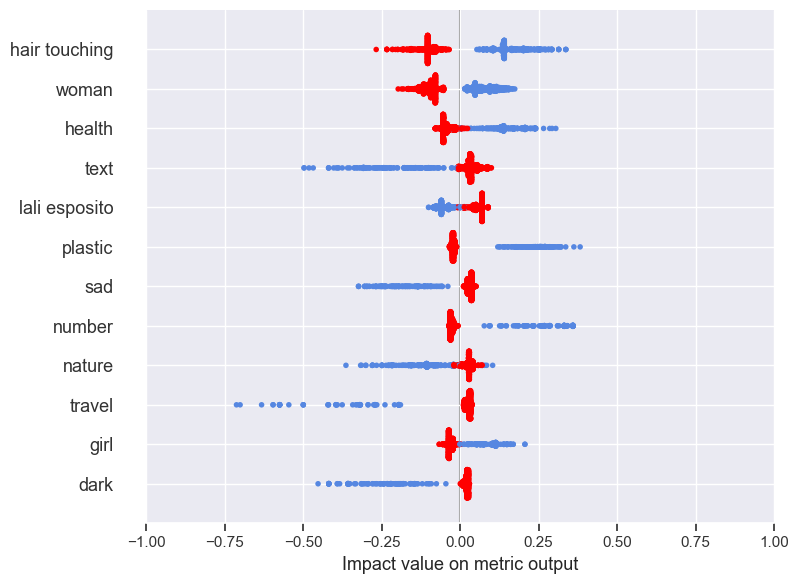

In [28]:
#colors = [(204/255, 0, 0), (0, 0, 204/255)]
colors = [(1, 0, 0), (86/255, 135/255, 225/255)]
n_bin = 100
cmap_parameter = LinearSegmentedColormap.from_list(name='name_list', colors=colors, N=n_bin)
#plt.figure(facecolor='white')
#plt.style.use('seaborn-whitegrid')
shap.summary_plot(shap_values, tags_aux, plot_type="dot", max_display=12, plot_size=(8,6), show=False, cmap=cmap_parameter, color_bar=False)
plt.xlim(-1,1)
plt.xlabel('Impact value on metric output')
#plt.savefig(f'Img/hair_care_beeswarm_for_{metric}.png')
plt.show()

In [29]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

In [ ]:
list_columns = ['logo_final_50pct', 'logo_final_50pct', 'soap', 'man', 'logo_final_25pct', 'facts']
list_index = []
for i,e in enumerate(shap_values.feature_names):
    if e in list_columns:
        list_index.append(i)

tags_aux = tags_aux.drop(columns=list_columns)

for i in list_index:
    del shap_values.feature_names[i]

shap_values.values = np.delete(shap_values.values, list_index, axis=1)
shap_values.data = np.delete(shap_values.data, list_index, axis=1)

In [ ]:
def hex_to_rgb(hex_color):
  hex_color = hex_color.lstrip('#')
  return [int(hex_color[i:i+2], 16) for i in range(0, 6, 2)]

Modificaciones en _bar.py:
- add parameter: show_sum_of_features
- add parameter: edge_color

En boruta sharp:
#from sklearn.datasets import load_breast_cancer, load_boston

In [30]:
tags_freq = tags.sum(0).reset_index().rename(columns={'tag_type':'tag_group', 'tag_name':'tag', 0:'usage_frequency'})
tags_freq["usage_frequency"] = tags_freq.usage_frequency / len(tags)

In [60]:
tags_score_per_asset = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
tags_score_per_asset['asset_id'] = tags_aux.reset_index().asset_id.copy()

In [62]:
tags_aux['dark'].loc[tags_aux['dark']==1].\
                    reset_index().\
                    drop(columns={'dark'}).\
                    merge(tags_score_per_asset[['dark', 'asset_id']], on='asset_id', how='inner').\
                    mean()[0]

-0.24978426293559874

array([[<AxesSubplot: title={'center': 'hair touching'}>]], dtype=object)

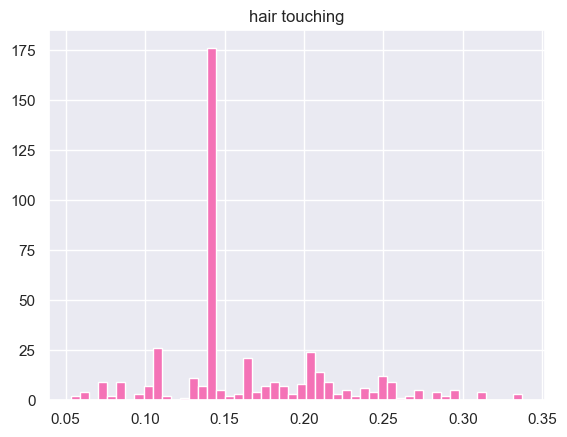

In [63]:
tags_aux['hair touching'].loc[tags_aux['hair touching']==1].\
                    reset_index().\
                    drop(columns={'hair touching'}).\
                    merge(tags_score_per_asset[['hair touching', 'asset_id']], on='asset_id', how='inner').hist('hair touching', bins=50)

array([[<AxesSubplot: title={'center': 'hair touching'}>]], dtype=object)

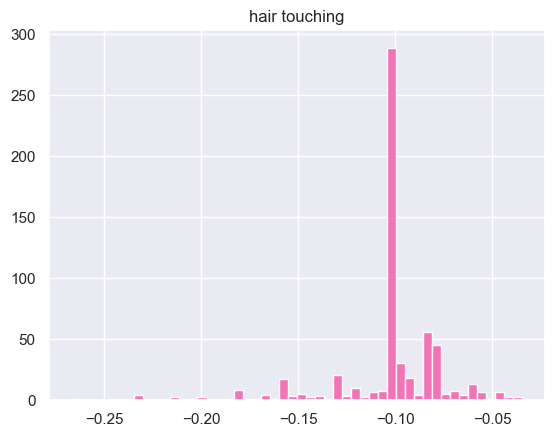

In [64]:
tags_aux['hair touching'].loc[tags_aux['hair touching']==0].\
                    reset_index().\
                    drop(columns={'hair touching'}).\
                    merge(tags_score_per_asset[['hair touching', 'asset_id']], on='asset_id', how='inner').hist('hair touching', bins=50)

In [ ]:
list_of_mean_tags = []
for col in tags_aux.columns:
    tag_mean = tags_aux[col].loc[tags_aux[col]==0].reset_index().drop(columns={col}).merge(tags_score_per_asset[[col, 'asset_id']], on='asset_id', how='inner').mean()[0]
    list_of_mean_tags.append(tag_mean)

data = {'tag': tags_aux.columns, 'tag_mean': list_of_mean_tags}

df_sign = pd.DataFrame(data)

In [ ]:
shap_results = pd.DataFrame({'score':tags_score_per_asset.drop(columns={'asset_id'}).abs().mean()})
shap_results = shap_results.reset_index().rename(columns={'index':'tag'})

In [ ]:
for i,value in enumerate(df_sign.tag_mean):
    if value<0:
        shap_results['score'][i] = shap_results['score'][i]*(-1)

In [ ]:
shap_results = pd.merge(shap_results, tags_freq, how='inner', on='tag')
shap_results['period'] = 'all'
shap_results['metric'] = metric

In [ ]:
shap_results_filter = shap_results.loc[shap_results.score.abs()>0.05]
shap_results_filter = shap_results_filter.reset_index()

In [ ]:
shap_results_filter.sort_values('score', ascending=False)

,index,tag,score,tag_group,usage_frequency,period,metric
5,864,plastic,0.060553,LABEL,0.158301,all,adrecallScore
0,343,dark,0.059703,LABEL,0.097490,all,adrecallScore
3,783,nature,-0.054035,LABEL,0.251931,all,adrecallScore
2,588,health,-0.059179,LABEL,0.270270,all,adrecallScore
4,797,number,-0.062754,LABEL,0.100386,all,adrecallScore
6,1238,woman,-0.073090,LABEL,0.518340,all,adrecallScore
7,1239,woman,-0.073090,OBJECT,0.001931,all,adrecallScore
1,474,fashion,-0.155331,LABEL,0.426641,all,adrecallScore


In [ ]:
shap_results_filter.loc[shap_results_filter.tag=='fashion']

,index,tag,score,tag_group,usage_frequency,period,metric
1,474,fashion,-0.155331,LABEL,0.426641,all,adrecallScore


In [ ]:
shap_results.to_csv(f'results/results_hair_care_for_{metric}.csv', index=False)

In [ ]:
#ca_plt.gg_scatterplot_install()

In [ ]:
#ca_plt.gg_scatterplot_2(shap_results_filter, metric, period='all', y_max=shap_results_filter.score.max()+0.01, y_min=shap_results_filter.score.min()-0.01, tags_plot=[],
#                        y_title='Estimated\nregression\ncoefficient',
#                        x_title='Usage frequency',n_tags=15,save=False,filename=f'Img/scatterplot_for_{metric}.png',
#                        width=900,height=600,plot=True, label_size=4, freq=0.5,y_ext=0.02,
#                        symbol_size=3,
#                        metrics_positive=['ctr','vvr','likes','shares','comments','vtr', 'bai', 'MEMORABILITY_ADRECALLPROB', 'adrecallScore'],
#                        metrics_negative=['cpc','cpm','cpmr','cpv'],
#                        colors=[],legend_labels=[],shapes=[20,17,8,18,12,13,9,1,2])

In [ ]:
shap_results_filter.loc[shap_results_filter.tag=='fashion']

,index,tag,score,tag_group,usage_frequency,period,metric
1,474,fashion,-0.155331,LABEL,0.426641,all,adrecallScore


In [ ]:
A =

SyntaxError: invalid syntax (12477046.py, line 1)

## Boruta shap

In [ ]:
%%time
model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=200,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

# Feature selection with BorutaShap for regression
Feature_Selector = BorutaShap(model=model,   
                              importance_measure='shap', 
                              classification=False)

Feature_Selector.fit(X=tags_aux, y=metrics[metric].fillna(0), n_trials=200, random_state=2)

#Feature_Selector.accepted
#Feature_Selector.shap_values

# Feature importance plot
#Feature_Selector.plot(which_features='accepted', figsize=(24,6), X_size=15)

# Select the best feature subset
X_fil = Feature_Selector.Subset()

  0%|          | 0/200 [00:00<?, ?it/s]

6 attributes confirmed important: ['clothing', 'no person', 'indoors', 'fashion', 'logo_top_right', 'human face']
758 attributes confirmed unimportant: ['prob la nueva variedad jengibre y ricino', 'exhibition', 'lav', ' vitamina a', 'art', 'portrait', 'tambin', 'purificacin', 'y dale', 'aplic la', 'desliz', 'empty', 'shopping', 'ahora en tu pelo', 'crema', 'bit', 'science', 'nightlife', 'window', 'disjunct', 'internet', 'peinate', 'skin', 'strategy', 'shelf', 'spot', 'para', 'artistic', 'particip por un meet  greet', 'achievement', 'encontranos en la playa varese para', 'botella', 'promocin igacin de compra de bienes yo contratacin de servicios valida en toda la republica argentina con excepcion de', 'stripe', 'libera', 'vitamin', 'bar', 'side view', 'logo_bottom', 'moisturize', 'tube', 'este', 'invention', 'paper', 'alphabet', 'para peinar', 'largo y', 'liber', ' peonas', 'y sin frizz', 'futuristic', 'performance', 'snow', 'tu u hidratado', 'unl', 'flower', 'ngela ponce', 'de peinados

In [ ]:
important_confirmed_attriubutes = Feature_Selector.accepted

print(important_confirmed_attriubutes)

['clothing', 'no person', 'indoors', 'fashion', 'logo_top_right', 'human face']


In [ ]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

## Lasso model

In [ ]:
# PARAMETROS MODIFICABLES ----------------------------------------------------------

date_col = 'created_time'
objective_col = 'objective'
tag_type_col = 'tag_type'
tag_name_col = 'tag_name'
tag_id_col = 'tag_id'

ad_date, objectives, tags, tags_freq = lasso.preprocess_lasso(df, index_col, date_col, objective_col,
                                                              metrics, tag_type_col, tag_name_col, tag_id_col)

¡Preprocess Lasso finished succesfully! Returning ad_date, objectives, tags and tags_freq.


training model: cpc for deltatime: all and objective: None
------> OK
training model: cpc_raw for deltatime: all and objective: None
------> OK


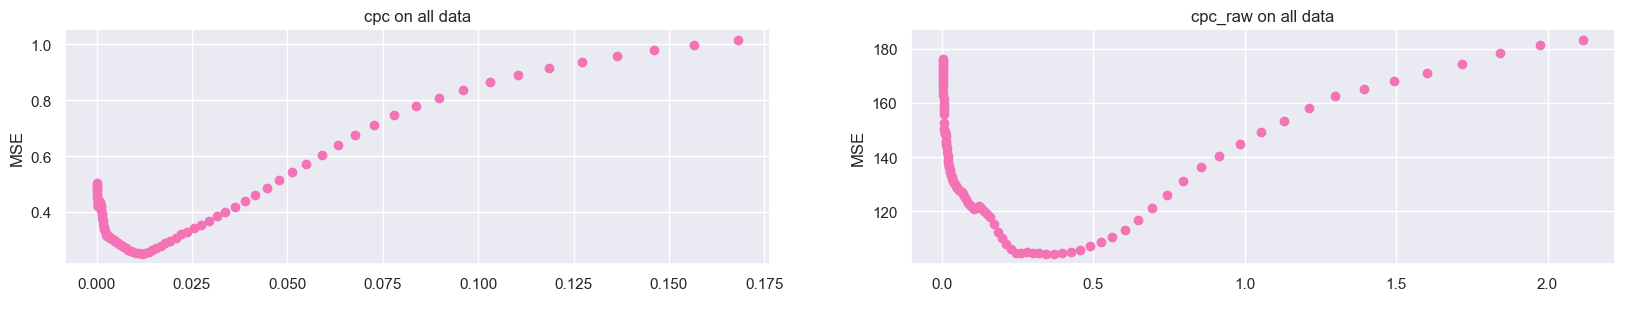

In [ ]:
# SETTING WEIGHTS
weight = df[['asset_id', 'carrusel_coef']].groupby('asset_id').first().iloc[:,0]
#----------------------------------


results = lasso.train_lasso(df, ad_date, objectives, tags, tags_freq, metrics, weight=weight,
                            use_weight=True, use_objective=False, use_time=False, 
                            delta_days=180, nfolds=10, iterations=10000)

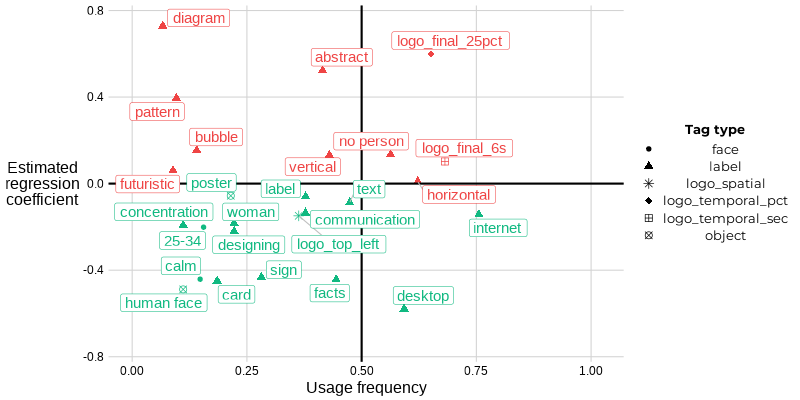

In [ ]:
ca_plt.gg_scatterplot_2(results,metric,period='all',y_max=None,y_min=None,tags_plot=[],\
    y_title='Estimated\nregression\ncoefficient',\
        x_title='Usage frequency',n_tags=15,save=False,filename='scatterplot.png',\
            width=900,height=600,plot=True, label_size=4, freq=0.5,y_ext=0.02,\
                symbol_size=3,\
                    metrics_positive=['ctr','vvr','likes','shares','comments','vtr'],\
                        metrics_negative=['cpc','cpm','cpmr','cpv'],
                        colors=[],legend_labels=[],shapes=[20,17,8,18,12,13])

In [ ]:
#import matplotlib
#import matplotlib.pyplot as plt
#
## Default SHAP colors
#default_pos_color = "#ff0051"
#default_neg_color = "#008bfb"
## Custom colors
#positive_color = "#00cc00"
#negative_color = "#cc0000"
## Plot Waterfall Plot
#shap.plots.waterfall(shap_values[0], show = False)
## Change the colormap of the artists
#for fc in plt.gcf().get_children():
#    for fcc in fc.get_children():
#        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
#            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
#                fcc.set_facecolor(positive_color)
#            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
#                fcc.set_color(negative_color)
#        elif (isinstance(fcc, plt.Text)):
#            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
#                fcc.set_color(positive_color)
#            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
#                fcc.set_color(negative_color)
#plt.show()